In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

In [2]:
data_path = '../data/CALC_STRAIGHT/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

In [3]:
print('STRAIGHT SEGMENTS:\t'+ str(len(files)))

STRAIGHT SEGMENTS:	187


In [4]:
X = pd.read_csv('../data/PN chuze/PN ataxie.csv',usecols=[0,1])
X

,File,Ts [s]
0,N-01-1-Char00,0.008
1,A-03-1-Char00,0.008
2,N-04-1-Char00,0.008
3,N-06-1-Char00,0.008
4,N-07-1-Char00,0.008
5,N-740516-Char00,0.017
6,N-535525-Char00,0.017
7,A-736123-Char00,0.017
8,A-715211-Char00,0.017
9,A-766012-Char00,0.017


### CALC FILE COLUMNS:
946 columns<br/>
01-X-z    01-V-x    01-V-y    01-V-z    01-Q-s    01-Q-x    01-Q-y  etc...

59 joints, for each joint 16 columns:<br/>
3 World coordinate displacement: X（X、Y、Z）,unit is meter.<br/>
3 World coordinate displacement: V（X、Y、Z）,unit is meter per second.<br/>
4 World coordinate module’s posture data: Q（W、X、Y、Z）.<br/>
3 Module coordinate accelerated speed: A（X、Y、Z），unit is g.<br/>
3 Module coordinate accelerated speed: M（X、Y、Z），unit is radian per second+ 2 columns<br/>
<br/>
2 boolean columns:<br/>
contactL<br/>
contactR<br/>
<br/>
59*16 + 2 = 946
<br/>
Additional in my csv file (not in calc):<br/>
OrigIndex



In [5]:
text_file = open('../data/JointNamesCalc.txt', "r")
joint_names_calc = text_file.read().split('\n')
len(joint_names_calc)

61

In [6]:
corpus_joints = ['Head','Neck','Spine3','Spine2','Spine1','Spine']
corpus_joints_ind = np.zeros([len(corpus_joints),1])
cc = 0
for c in corpus_joints:
    corpus_joints_ind[cc] = joint_names_calc.index(c)
    cc+=1
corpus_joints_ind

array([[15.],
       [16.],
       [17.],
       [18.],
       [19.],
       [20.]])

In [7]:
left_foot_ind = joint_names_calc.index('LeftFoot')
left_foot_ind

6

In [8]:
right_foot_ind = joint_names_calc.index('RightFoot')
right_foot_ind

3

N-04-1-Char00part7seg-3.csv


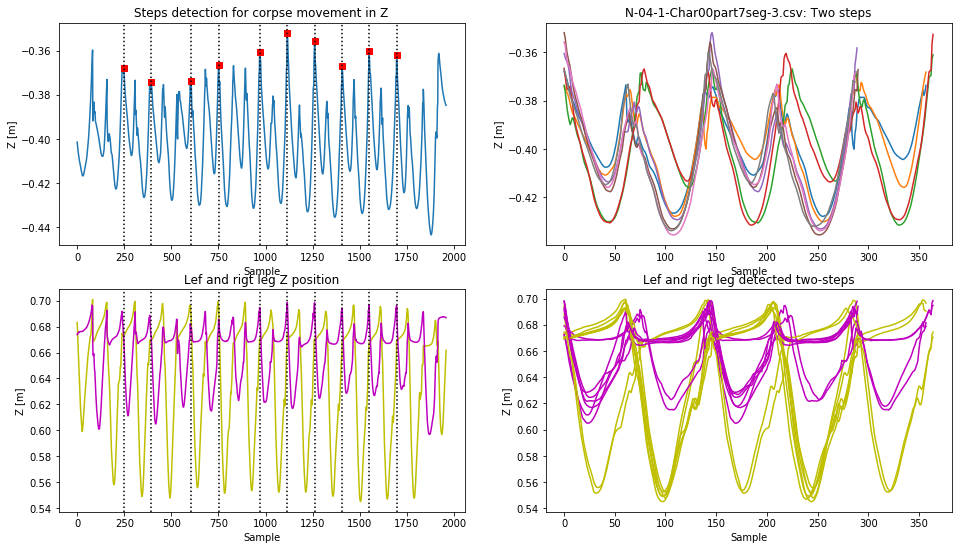

In [9]:
for file in files:
    subject =  file.split(sep='Char00',maxsplit=1)[0]+'Char00'
    print(file)
    
    df = pd.read_csv(data_path + file)
    N = np.size(df,axis=0)
    # Check for the T_sampling from bvh file
    T_sampling = X.loc[X['File'] == subject,'Ts [s]'].values
    # Create time vector for this part
    time = np.linspace(0,N,num=N)*T_sampling
    
    col_list = df.columns.to_list()
    position_cols = [s for s in col_list if "X" in s]
    xdf = df.filter(position_cols,axis=1)
    
    # CORPUS
    corpus_cols_ind = []
    for c in corpus_joints_ind:
        for col in xdf.columns.to_list():
            if (str(int(c))) in col:
                corpus_cols_ind.append(xdf.columns.to_list().index(col))

    corpus = xdf.filter(xdf.columns[corpus_cols_ind],axis=1)
    corpus_cols = corpus.columns.to_list()
    zdim_cols = [s for s in corpus_cols if "z" in s]
    x = np.zeros([N,1])
    x = corpus.filter(zdim_cols,axis=1).mean(axis=1).to_numpy()
    
    # LEGS
    leftleg_cols = []
    for col in xdf.columns.to_list():
        if ('0' + str(int(left_foot_ind))) in col:
            leftleg_cols.append(xdf.columns.to_list().index(col))
    rightleg_cols = []
    for col in xdf.columns.to_list():
        if ('0' + str(int(right_foot_ind))) in col:
            rightleg_cols.append(xdf.columns.to_list().index(col))

    leg_L = xdf.filter(xdf.columns[leftleg_cols],axis=1)
    leg_R = xdf.filter(xdf.columns[rightleg_cols],axis=1)

    x = corpus.filter(zdim_cols,axis=1).mean(axis=1).to_numpy()
    
    # Distance threshold for findpeaks = 1 second
    TH_dist = 1 / T_sampling
    

    peaks, _ = find_peaks(x,distance=TH_dist)
    
    if len(peaks) > 4:
        peaks = peaks[1:-1]
    
    #if len(peaks) > 30:

    fig, ax = plt.subplots(2, 2, figsize=(16,9))
    ax[0,0].plot(x)
    ax[0,0].plot(peaks, x[peaks], "rs")
    ax[0,0].set_xlabel('Sample')
    ax[0,0].set_ylabel('Z [m]')
    ax[0,0].set_title('Steps detection for corpse movement in Z')        



    #if len(peaks) % 2 == 0:
    #    peaks = peaks[1:]
    for n in range(0,len(peaks)-2):
        tmp_x = x[peaks[n]:peaks[n+2]]
        tmp_LL = leg_L.iloc[peaks[n]:peaks[n+2],2].to_numpy()
        tmp_RL = leg_R.iloc[peaks[n]:peaks[n+2],2].to_numpy()
        ax[0,1].plot(tmp_x)
        ax[1,1].plot(tmp_LL,'y')
        ax[1,1].plot(tmp_RL,'m')


    ax[0,1].set_xlabel('Sample')
    ax[0,1].set_title(file + ': Two steps')
    ax[0,1].set_ylabel('Z [m]')

    ax[1,0].plot(leg_L.iloc[:,2],'y')
    ax[1,0].plot(leg_R.iloc[:,2],'m')

    for xc in peaks:
        ax[0,0].axvline(x=xc, color='k', linestyle=':')
        ax[1,0].axvline(x=xc, color='k', linestyle=':')

    ax[1,0].set_xlabel('Sample')
    ax[1,0].set_title('Lef and rigt leg Z position')
    ax[1,0].set_ylabel('Z [m]')

    ax[1,1].set_xlabel('Sample')
    ax[1,1].set_title('Lef and rigt leg detected two-steps')
    ax[1,1].set_ylabel('Z [m]')

        #plt.savefig(file[:-4] + '.png')
        #plt.close()
    break


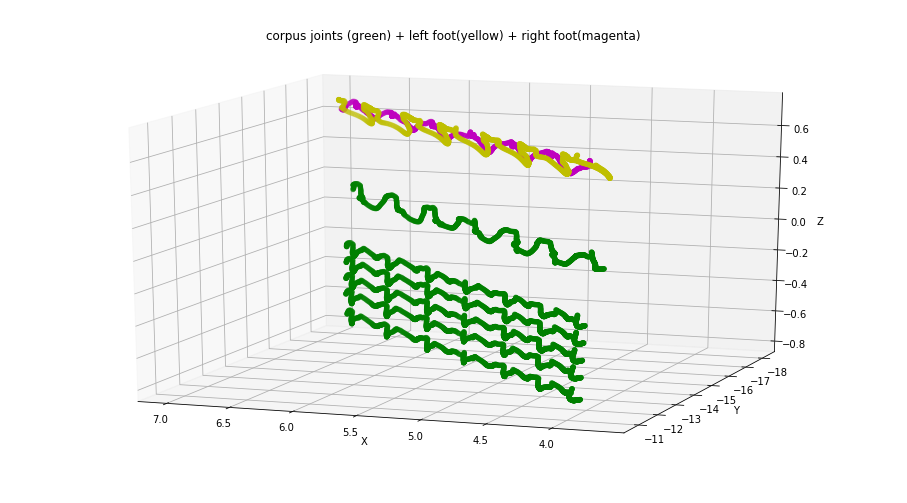

In [10]:
import plotly.graph_objects as go
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='3d')

N = 1000

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

xxdf = xdf.iloc[0:N,leftleg_cols]

xdim_cols = [s for s in xxdf if "x" in s]
ydim_cols = [s for s in xxdf if "y" in s]
zdim_cols = [s for s in xxdf if "z" in s]

xs = xxdf.filter(xdim_cols,axis=1).to_numpy()
ys = xxdf.filter(ydim_cols,axis=1).to_numpy()
zs = xxdf.filter(zdim_cols,axis=1).to_numpy()

ax.scatter(xs, ys, zs, c='y')

xxdf = xdf.iloc[0:N,rightleg_cols]

xdim_cols = [s for s in xxdf if "x" in s]
ydim_cols = [s for s in xxdf if "y" in s]
zdim_cols = [s for s in xxdf if "z" in s]

xs = xxdf.filter(xdim_cols,axis=1).to_numpy()
ys = xxdf.filter(ydim_cols,axis=1).to_numpy()
zs = xxdf.filter(zdim_cols,axis=1).to_numpy()

ax.scatter(xs, ys, zs, c='m')

xxdf = xdf.iloc[1:N,corpus_cols_ind]

xdim_cols = [s for s in xxdf if "x" in s]
ydim_cols = [s for s in xxdf if "y" in s]
zdim_cols = [s for s in xxdf if "z" in s]

xs = xxdf.filter(xdim_cols,axis=1).to_numpy()
ys = xxdf.filter(ydim_cols,axis=1).to_numpy()
zs = xxdf.filter(zdim_cols,axis=1).to_numpy()

ax.scatter(xs, ys, zs, c='g')



ax.azim = 110
ax.elev = 15
ax.set_title('corpus joints (green) + left foot(yellow) + right foot(magenta)')

plt.show()


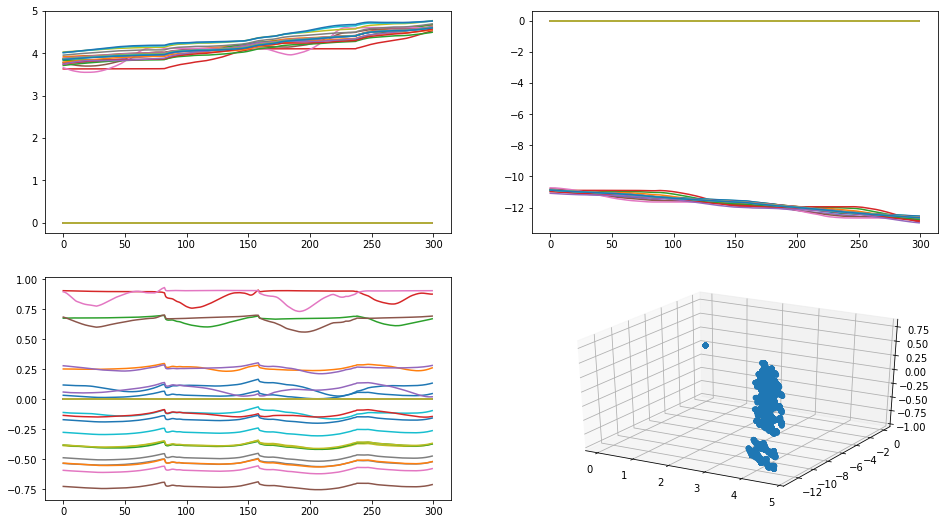

In [11]:
xxdf = xdf.iloc[0:300,:]

xdim_cols = [s for s in xxdf if "x" in s]
ydim_cols = [s for s in xxdf if "y" in s]
zdim_cols = [s for s in xxdf if "z" in s]

xs = xxdf.filter(xdim_cols,axis=1).to_numpy()
ys = xxdf.filter(ydim_cols,axis=1).to_numpy()
zs = xxdf.filter(zdim_cols,axis=1).to_numpy()

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(221)
ax.plot(xs)
ax = fig.add_subplot(222)
ax.plot(ys)
ax = fig.add_subplot(223)
ax.plot(zs)
ax = fig.add_subplot(224, projection='3d')
ax.scatter(xs, ys, -zs)
#ax.azim = 105
#ax.elev = 15
plt.show()

In [12]:
peaks

array([ 247,  393,  605,  751,  970, 1116, 1260, 1407, 1549, 1695])

In [13]:
df.head()

,OrigIndex,01-X-x,01-X-y,01-X-z,01-V-x,01-V-y,01-V-z,01-Q-s,01-Q-x,01-Q-y,...,59-Q-s,59-Q-x,59-Q-y,59-Q-z,59-A-x,59-A-y,59-A-z,59-W-x,59-W-y,59-W-z
0,57786,3.8574,-10.8699,0.0318,0.4837,-0.8069,0.0062,0.5396,0.4174,0.6150,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,57787,3.8599,-10.8763,0.0311,0.4660,-0.8002,0.0002,0.5394,0.4166,0.6169,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,57788,3.8627,-10.8826,0.0302,0.4522,-0.7798,0.0025,0.5392,0.4158,0.6186,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,57789,3.8654,-10.8889,0.0294,0.4450,-0.7722,0.0057,0.5392,0.4151,0.6203,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57790,3.8679,-10.8954,0.0285,0.4378,-0.7357,0.0139,0.5392,0.4142,0.6219,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
StepIndex = df.OrigIndex[peaks]
StepIndex

247     58033
393     58179
605     58391
751     58537
970     58756
1116    58902
1260    59046
1407    59193
1549    59335
1695    59481
Name: OrigIndex, dtype: int64